<a href="https://colab.research.google.com/github/joselyne20/Advanced-computer-vision/blob/main/tutorial_1b_mnist1d_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial 1b: MNIST-1D Classification**

This tutorial designs a network for MNIST-1D classification. MNIST-1D dataset is a simplified version of the famous MNIST dataset but with one-dimensional data. This is useful for understanding and visualizing machine learning concepts in a more tractable setting. See more details about the dataset [here](https://github.com/greydanus/mnist1d).

Work through the cells below, running each cell in turn.

The code is adapted from https://github.com/udlbook/udlbook/blob/main/Notebooks/Chap11/11_2_Residual_Networks.ipynb


In [ ]:
# Run this if you're in a Colab to make a local copy of the MNIST 1D repository
!git clone https://github.com/greydanus/mnist1d

Cloning into 'mnist1d'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 155 (delta 52), reused 124 (delta 26), pack-reused 0
Receiving objects: 100% (155/155), 6.48 MiB | 26.11 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [ ]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import torch.nn.functional as F
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading and Inspecting the MNIST-1D Dataset

In this section, we are working with the MNIST-1D dataset.

### Loading the Dataset
- **Retrieve Dataset Arguments:**
  - `args = mnist1d.data.get_dataset_args()`: This line gets the default arguments required for loading the MNIST-1D dataset. These arguments could include specifics like batch size, normalization factors, etc.
- **Get Dataset:**
  - `data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)`: Here, the dataset is loaded with the specified arguments. The parameters include:
    - `path='./mnist1d_data.pkl'`: Indicates where the dataset should be loaded from or saved to.
    - `download=False`: This specifies that the dataset should not be downloaded if it's not found at the given path.
    - `regenerate=False`: Indicates that the dataset should not be regenerated if it already exists.

### Dataset Structure
- The MNIST-1D dataset contains training and test data, split into inputs (`x` and `x_test`) and outputs (`y` and `y_test`):
  - `data['x']`: Training inputs.
  - `data['y']`: Training outputs (labels).
  - `data['x_test']`: Test inputs.
  - `data['y_test']`: Test outputs (labels).

### Inspecting the Data
- **Training Set Size:**
  - `print("Examples in training set: {}".format(len(data['y'])))`: This line prints the number of examples in the training set by checking the length of the training labels.
- **Test Set Size:**
  - `print("Examples in test set: {}".format(len(data['y_test'])))`: Similarly, this line prints the number of examples in the test set.
- **Length of Each Example:**
  - `print("Length of each example: {}".format(data['x'].shape[-1]))`: This line prints the length of each example in the dataset. Since the data is one-dimensional, the length refers to the number of features in each example.


In [ ]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [ ]:
data['x'][:]


array([[-0.33200567, -0.47191037, -0.77869708, ..., -0.7167305 ,
        -0.96195825, -0.89016639],
       [ 1.96548088,  2.30021254,  2.21339278, ..., -1.68751297,
        -1.42642212, -1.36421511],
       [-0.01930303,  0.07863308,  0.62488909, ..., -1.08555748,
        -1.79809121, -2.3153282 ],
       ...,
       [-1.69449348, -1.2805858 , -0.65125255, ..., -0.72365942,
        -0.38266551, -0.03165042],
       [ 0.99646721,  0.80844603,  0.1553411 , ..., -0.30286571,
        -0.28555128, -0.1183879 ],
       [-0.6939948 , -0.27532169,  0.29267968, ..., -1.21624513,
        -1.4649417 , -1.65099286]])

In [24]:
 # Load in the data
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)


## Implementing a Residual Network for MNIST-1D Data

In this code snippet, we define a `ResidualNetwork` class, which is a type of neural network model suited for handling the MNIST-1D dataset. This dataset involves 40 input dimensions corresponding to offsets in the MNIST1D template and 10 output dimensions corresponding to the 10 digit classes.

### Network Dimensions
- `D_i = 40`: Represents the number of input dimensions (40 offsets in the MNIST1D template).
- `D_o = 10`: Represents the number of output dimensions (10 digits).

### ResidualNetwork Class
- **Inheritance:** The `ResidualNetwork` class inherits from `torch.nn.Module`, the base class for all neural network modules in PyTorch.
- **Constructor (`__init__`):**
  - Parameters:
    - `input_size`: The size of the input layer (number of input features).
    - `output_size`: The size of the output layer (number of classes).
    - `hidden_size=100`: The size of the hidden layers, defaulted to 100.
  - Layers:
    - `self.linear1`: The first linear layer maps from `input_size` to `hidden_size`.
    - `self.linear2` and `self.linear3`: Two additional linear layers, each mapping from `hidden_size` to `hidden_size`.
    - `self.linear4`: The final linear layer maps from `hidden_size` to `output_size`.
  - `print("Initialized MLPBase model with {} parameters".format(self.count_params()))`: This prints out the total number of parameters in the model, calculated by the `count_params` method.
- **count_params Method:**
  - Returns the total number of trainable parameters in the model.
- **Forward Pass (`forward`):**
  - Defines how the input `x` flows through the network.
  - `h1 = self.linear1(x)`: First linear transformation.
  - `h2 = F.relu(self.linear2(h1))` and `h3 = F.relu(self.linear3(h2))`: Two hidden layers with ReLU activation functions.
  - `return self.linear4(h3)`: The output is obtained after the final linear transformation.



In [55]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        self.linear2 = nn.Linear(out_features, out_features)

    def forward(self, x):
        residual = x
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return F.relu(x + residual)

class ResidualNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100, num_blocks=3):
        super(ResidualNetwork, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_size)
        self.residual_blocks = nn.ModuleList([ResidualBlock(hidden_size, hidden_size) for _ in range(num_blocks)])
        self.linear_out = nn.Linear(hidden_size, output_size)
        print("Initialized ResidualNetwork model with {} parameters".format(self.count_params()))

    def count_params(self):
        return sum(p.numel() for p in self.parameters())

    def forward(self, x):
        x = F.relu(self.linear_in(x))
        for block in self.residual_blocks:
            x = block(x)
        return self.linear_out(x)

# Example usage:
D_i = 40
D_o = 10
#resnet_model = ResidualNetwork(input_size=D_i, output_size=D_o)


In [38]:
# There are 40 input dimensions and 10 output dimensions for this data
# The inputs correspond to the 40 offsets in the MNIST1D template.
D_i = 40
# The outputs correspond to the 10 digits
D_o = 10

class ResidualNetwork(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(ResidualNetwork, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.linear4 = nn.Linear(hidden_size, output_size)
    print("Initialized MLPBase model with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

  # This is not yet a residual network, we need to revise this part in tutorial_1c
  def forward(self, x):
    h1 = self.linear1(x)
    h2 = F.relu(self.linear2(h1))
    h3 = F.relu(self.linear3(h2))
    return self.linear4(h3)


In [56]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

## Setting Up the Neural Network for MNIST-1D Classification

In this segment, we initialize and configure the neural network model, loss function, optimizer, learning rate scheduler, and data for the MNIST-1D dataset.

### Model Initialization
- `model = ResidualNetwork(40, 10)`: Creates an instance of the `ResidualNetwork` class with 40 input dimensions and 10 output dimensions. This model will be used for the MNIST-1D digit classification task.

### Loss Function
- **Cross Entropy Loss:**
  - `loss_function = nn.CrossEntropyLoss()`: Defines the loss function as Cross Entropy Loss, which is commonly used for classification tasks. It combines Log Softmax and Negative Log-Likelihood Loss in one single class.

### Optimizer
- **Stochastic Gradient Descent (SGD):**
  - `optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)`: Initializes an SGD optimizer. It updates the model's weights based on the computed gradients.
    - `model.parameters()`: Passes the parameters of the model to the optimizer.
    - `lr = 0.05`: Sets the learning rate to 0.05.
    - `momentum=0.9`: Sets the momentum factor to 0.9, which helps in accelerating the optimizer in the direction of consistent gradients.

### Learning Rate Scheduler
- **Step Learning Rate Decay:**
  - `scheduler = StepLR(optimizer, step_size=20, gamma=0.5)`: Implements a learning rate decay scheduler.
    - `step_size=20`: The learning rate is decreased every 20 epochs.
    - `gamma=0.5`: The factor by which the learning rate is reduced. Here, it is halved.

### Data Preparation
- **Converting Data to Torch Tensors:**
  - The input data (`train_data_x` and `val_data_x`) and labels (`train_data_y` and `val_data_y`) are converted to PyTorch tensors. This conversion is necessary to utilize PyTorch's efficient tensor operations during training.
    - `x_train = torch.tensor(train_data_x.transpose().astype('float32'))`: Transposes and converts the training data to float32 tensors.
    - `y_train = torch.tensor(train_data_y.astype('long'))`: Converts the training labels to long tensors.
    - `x_val = torch.tensor(val_data_x.transpose().astype('float32'))`: Transposes and converts the validation data to float32 tensors.
    - `y_val = torch.tensor(val_data_y.astype('long'))`: Converts the validation labels to long tensors.

In [57]:
#Define the model
model = ResidualNetwork(40, 10)

# Choose cross entropy loss function
loss_function = nn.CrossEntropyLoss()
# Construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# Object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
# Convert data to torch tensors
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long'))
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long'))

Initialized ResidualNetwork model with 65710 parameters


## Training Loop for the Neural Network

In this section, we define the training loop for our neural network model. This loop iterates over the dataset multiple times (epochs), updating the model's parameters based on the loss computed from the predictions and the actual data.

### Data Loader Setup
- `data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))`: This line creates a data loader for the training data.
  - `TensorDataset(x_train, y_train)`: Wraps tensors into a dataset.
  - `batch_size=100`: Each batch will contain 100 samples.
  - `shuffle=True`: Shuffles the data every epoch to prevent the model from learning the order of the data.
  - `worker_init_fn=np.random.seed(1)`: Ensures reproducibility by setting a seed for the random number generator in each worker.

### Model Weight Initialization
- `model.apply(weights_init)`: Initializes the model's weights using the `weights_init` function defined earlier.

### Training Loop Setup
- `n_epoch = 100`: The model will be trained for 100 epochs.
- Arrays to store losses and error rates for both training and validation data are initialized.

### Epoch Loop
- **Outer Loop Over Epochs:**
  - `for epoch in range(n_epoch)`: Iterates over the number of epochs.
- **Batch Loop:**
  - `for i, data in enumerate(data_loader)`: Iterates over each batch in the data loader.
  - `x_batch, y_batch = data`: Retrieves inputs and labels for the current batch.
  - `optimizer.zero_grad()`: Resets gradient information to zero.
  - `pred = model(x_batch)`: Forward pass - computes the predicted outputs.
  - `loss = loss_function(pred, y_batch)`: Computes the loss.
  - `loss.backward()`: Backward pass - computes the gradients.
  - `optimizer.step()`: Performs a single optimization step (parameter update).

### Evaluation and Statistics
- After each epoch, the model's performance is evaluated on both the training and validation datasets.
- The error rate and loss for both training and validation sets are calculated and stored.
- The performance metrics for each epoch are printed out.
- `scheduler.step()`: Adjusts the learning rate according to the scheduler.


In [58]:
# Load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# Loop over the dataset n_epoch times
n_epoch = 100
# Store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_val = np.zeros((n_epoch))
errors_val = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # Loop over batches
  for i, data in enumerate(data_loader):
    # Retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # Zero the parameter gradients
    optimizer.zero_grad()
    # Forward pass -- calculate model output
    pred = model(x_batch)
    # Compute the loss
    loss = loss_function(pred, y_batch)
    # Backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_val = model(x_val)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_val[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')

  # Tell scheduler to consider updating learning rate
  scheduler.step()

Epoch     0, train loss 1.732187, train error 70.28,  val loss 1.758264, percent error 72.00
Epoch     1, train loss 1.598942, train error 65.03,  val loss 1.646047, percent error 67.50
Epoch     2, train loss 1.473980, train error 59.25,  val loss 1.519214, percent error 64.30
Epoch     3, train loss 1.246361, train error 49.90,  val loss 1.350332, percent error 55.30
Epoch     4, train loss 1.161279, train error 45.60,  val loss 1.284395, percent error 52.00
Epoch     5, train loss 1.178181, train error 46.72,  val loss 1.380627, percent error 54.80
Epoch     6, train loss 0.960919, train error 37.28,  val loss 1.234987, percent error 49.40
Epoch     7, train loss 0.895267, train error 35.07,  val loss 1.225174, percent error 47.60
Epoch     8, train loss 0.803277, train error 31.55,  val loss 1.143896, percent error 44.70
Epoch     9, train loss 0.725611, train error 27.93,  val loss 1.162935, percent error 45.10
Epoch    10, train loss 0.718211, train error 28.15,  val loss 1.17182

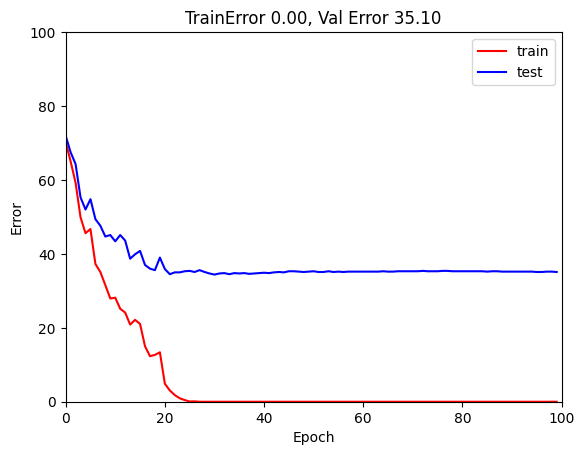

In [59]:
 # Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Val Error %3.2f'%(errors_train[-1],errors_val[-1]))
ax.legend()
plt.show()

In [ ]:
ire

## What's Next?

The primary motivation of residual networks is to allow training of much deeper networks. Change the network structure to become a residual network.

TODO: Try running this network with and without the residual connections.  Does adding the residual connections change the performance?

#draft ↓

In [ ]:
x = np.array([i for i in range(30)])
x.shape, x

((30,),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]))

In [ ]:
y = x.reshape(30, 1)
y.shape, y

In [23]:
n = np.array([1,2,4,5,6])
n.reshape
n

TypeError: only integer scalar arrays can be converted to a scalar index